# Data Project - MES

Importing the required packages to run the code:

In [1]:
import geopandas as gpd
import folium
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from matplotlib_venn import venn2

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# user written modules
import dataproject


# Introduction into the Project

In this project we look at the relationship between the age distribution and motor vehicle distribution in Germany. More specifically, we look at the regional and age related trends of vehicles and its distribution in Germany. W

To analyse this relationship we gather data from the german federal statiscal office (Statistisches Bundesamt). We use the data sets for age distribution in german pre-defined counties and data for vehicles in these pre-defined counties.

The analysis is structured as follows. Firstly, we import and clean the two data sets seperately. Secondly, we merge the two data sets into one and convert it into geodata. Lastly, we plot the results as well as discuss the results and its implications.

# Step 1: Read and Clean Data

We first import our age and vehicle data from the german statistical office and drop every irrelevant variable (columns) as well as missing values (rows). Furthermore, we rename the variables from german to english for greater understandability for the reader.

# Age Distribution Data

We merged age ranges together to get 10 year ranges instead of smaller ranges which were provided in the data. This was done to have a greater number of observations in one age range.

We dropped the age ranges until 20 as those are not to drive. We recognize that 18-20 are legally allowed to drive, however we decided to exclude that age group as it would have been significantly smaller than all other age groups.

We use ratios since contituencies differ significantly in population. Thus, population-dense counties might skew our results if we use absolute values. Thus, we use age range population to total population ratios.

In [2]:
# A. Import Data on Age Distribution in German counties from federal statistics department
# We imported the data into the 'dataX.csv'
dfA = pd.read_csv('dataX.csv', sep = ';')

# B. Start cleaning by removing all rows which are empty
dfA.replace('-',None, inplace = True)
dfA.dropna(subset=['unter 3 Jahre'], inplace = True)

# C. Convert to numeric
dfA = dfA.apply(pd.to_numeric, errors = 'ignore')

# D. Age ranges 
# D.1 Setting the age ranges
age_ranges = [
    ('20 bis unter 25 Jahre', '25 bis unter 30 Jahre'),
    ('30 bis unter 35 Jahre', '35 bis unter 40 Jahre'),
    ('40 bis unter 45 Jahre', '45 bis unter 50 Jahre'),
    ('50 bis unter 55 Jahre', '55 bis unter 60 Jahre')
]

# D.2 Loop over the age ranges and add them together
for age_range in age_ranges:
    col1, col2 = age_range
    lower_bound = int(col1.split()[0])
    upper_bound = int(col2.split()[0])
    new_col_name = f'{lower_bound}-{upper_bound}'
    dfA[new_col_name] = dfA[col1] + dfA[col2]

# D.3 Drop irrelevant age ranges
dfA.drop(['unter 3 Jahre', '3 bis unter 6 Jahre', '6 bis unter 10 Jahre', '10 bis unter 15 Jahre', '15 bis unter 18 Jahre', '18 bis unter 20 Jahre', '20 bis unter 25 Jahre', '25 bis unter 30 Jahre', '30 bis unter 35 Jahre', '35 bis unter 40 Jahre', '40 bis unter 45 Jahre', '45 bis unter 50 Jahre', '50 bis unter 55 Jahre', '55 bis unter 60 Jahre', '60 bis unter 65 Jahre'], axis=1, inplace=True)

# E. Remame the columns 
dfA_final = dfA.rename(columns = {'65 bis unter 75 Jahre':'65 to under 75 years', 'Landkreis':'County', 'Datum':'Date','75 Jahre und mehr':'75 years and older', 'Insgesamt':'Total', '20-25':'20 to under 30 years', '30-35':'30 to under 40 years', '40-45':'40 to under 50 years', '50-55':'50 to under 60 years' })

# F. Ratios
# F.1 Add column to construct a ratio between >65year olds in comparison to whole population
dfA_final["65+years/Total"] = (dfA_final["65 to under 75 years"] + dfA_final["75 years and older"]) / dfA_final["Total"]

# F.2 Age groups
age_group =[
    ('20 to under 30 years'),
    ('30 to under 40 years'), 
    ('40 to under 50 years'), 
    ('50 to under 60 years'), 
]

# F.3 Calculate ratios
for age_group in age_group:
    dfA_final[f"{age_group}/Total"] = dfA_final[age_group] / dfA_final["Total"]

# G. New column order 
new_column_order = ['Date', 'B-code', 'County', '20 to under 30 years', '30 to under 40 years', '40 to under 50 years', '50 to under 60 years', '65 to under 75 years', '75 years and older','20 to under 30 years/Total','30 to under 40 years/Total', '40 to under 50 years/Total', '50 to under 60 years/Total', '65+years/Total', 'Total']
dfA_final = dfA_final.reindex(columns=new_column_order)

# H. Display the modified DataFrame
dfA_final.head()

,Date,B-code,County,20 to under 30 years,30 to under 40 years,40 to under 50 years,50 to under 60 years,65 to under 75 years,75 years and older,20 to under 30 years/Total,30 to under 40 years/Total,40 to under 50 years/Total,50 to under 60 years/Total,65+years/Total,Total
0,31.12.2021,1001,"Flensburg, kreisfreie Stadt",16718,11598,9832,12658,8861,9532,0.183486,0.127292,0.107910,0.138926,0.201870,91113
1,31.12.2021,1002,"Kiel, kreisfreie Stadt",44571,37198,27421,34354,22414,24416,0.181004,0.151062,0.111357,0.139513,0.190178,246243
2,31.12.2021,1003,"L�beck, kreisfreie Stadt",28215,27609,24774,33512,23374,27556,0.130458,0.127656,0.114548,0.154949,0.235485,216277
3,31.12.2021,1004,"Neum�nster, kreisfreie Stadt",9526,10015,9131,12280,8583,9749,0.119830,0.125981,0.114861,0.154473,0.230603,79496
4,31.12.2021,1051,"Dithmarschen, Landkreis",14099,14183,14565,22702,16993,17130,0.105241,0.105868,0.108719,0.169457,0.254708,133969


# Motor Vehicle Data

After importing the data set on the distribution of motor vehicles for german counties, we dropped empty columns and empty rows.
Afterwards, we merged columns together which we regard as similar for our analysis. 
Then, we dropped useless columns that contain values but are not important for our analysis. Then, we renamed the variables to engish names to improve the readability. 
Finally, we created ratios, to set the message of each variable independent from the overall county size.

In [3]:
# A. Import Data on Motor Vehicles Distribution in German counties from the German Federal Statistics Department
# A.1 We imported the data into the 'dataY.csv'
transport = pd.read_csv('dataY.csv', sep = ';')

# B. First Preparation of the raw data set
# B.1 Drop empty columns
transport.drop(['Leichtkraftraeder', 'Gewoehnliche Zugmaschinen'], axis = 1, inplace=True)

# B.2 Drop empty raws
transport.replace('-',None, inplace = True)
transport.dropna(subset=['Kfz'], inplace = True)

# C. Transform strings to numbers
transport = transport.apply(pd.to_numeric, errors = 'ignore')

# D. Creating sums of existing columns
# D.1 Creating Zweiraeder as sum of Kraftraeder and Motorraeder
transport['Zweiraeder'] = transport[['Kraftraeder', 'Motorraeder']].sum(axis=1)

# D.2 Creating Pkw1 as sum of Pkw mit Ottomotor and Dieselmotor
transport['Pkw1'] = transport[['Pkw mit Ottomotor', 'Pkw mit Dieselmotor']].sum(axis=1)

# D.3 Creating KFZ as sum of ZWeiraeder, Pkw1 and Wohnmobile 
transport['KFZ'] = transport[['Zweiraeder', 'Pkw1', 'Wohnmobile']].sum(axis=1)

# E. Dropping useless columns
# E.1 Create list of columns, that we want to keep
keep_columns = ['Datum', ' B-code', ' Stadt', 'Pkw mit Ottomotor', 'Pkw mit Dieselmotor', 'Pkw1', 'Wohnmobile', 'Zweiraeder', 'KFZ'] 

# E.2 Delete every other column
transport = transport.loc[:, keep_columns]

# F. Rename the columns
transport.rename(columns = {'Datum':'date', ' B-code':'B-code', ' Stadt':'County', 'Pkw mit Ottomotor':'cars petrol', 'Pkw mit Dieselmotor': 'cars diesel', 'Pkw1':'cars', 'Wohnmobile':'campers', 'Zweiraeder':'two-wheelers', 'KFZ':'vehicles'}, inplace=True)

# G. Creating new ratios
# G.1 Create the lists for the ratios
numerator_columns = ['cars petrol', 'cars diesel', 'campers', 'two-wheelers']
denominator_columns = ['vehicles', 'vehicles', 'vehicles', 'vehicles']
 
# G.2 Create the if loop to create the ratios
for i in range(len(numerator_columns)):
    ratio = transport[numerator_columns[i]] / transport[denominator_columns[i]]
    transport[numerator_columns[i] + '/' + denominator_columns[i]] = ratio

# H. Show the final dataFrame for Motor Vehicles 
transport.head()

,date,B-code,County,cars petrol,cars diesel,cars,campers,two-wheelers,vehicles,cars petrol/vehicles,cars diesel/vehicles,campers/vehicles,two-wheelers/vehicles
0,01.01.2022,1001,"Flensburg, kreisfreie Stadt",26809,16230,43039,1489,5826,50354,0.532411,0.322318,0.029571,0.115701
1,01.01.2022,1002,"Kiel, kreisfreie Stadt",71089,35234,106323,3650,16458,126431,0.562275,0.278682,0.028870,0.130174
2,01.01.2022,1003,"L�beck, kreisfreie Stadt",66824,30127,96951,2359,16839,116149,0.575330,0.259382,0.020310,0.144978
3,01.01.2022,1004,"Neum�nster, kreisfreie Stadt",26943,14163,41106,864,6845,48815,0.551941,0.290136,0.017699,0.140223
4,01.01.2022,1051,"Dithmarschen, Landkreis",48386,32319,80705,2184,15976,98865,0.489415,0.326900,0.022091,0.161594


# Step 2: Merge the two datasets

After cleaning both individual data sets, we continue to merge the data together. Our aim is to perform the merge based on the B-Code. For each individual row, we merge all values together, that have the same B-Code. 

In [4]:
# A. Merge Age Distribution and Motor Vehicles datasets
merged = pd.merge(dfA_final, transport, on='B-code')

# B. Display the merged data set in a table
merged.head()

,Date,B-code,County_x,20 to under 30 years,30 to under 40 years,40 to under 50 years,50 to under 60 years,65 to under 75 years,75 years and older,20 to under 30 years/Total,...,cars petrol,cars diesel,cars,campers,two-wheelers,vehicles,cars petrol/vehicles,cars diesel/vehicles,campers/vehicles,two-wheelers/vehicles
0,31.12.2021,1001,"Flensburg, kreisfreie Stadt",16718,11598,9832,12658,8861,9532,0.183486,...,26809,16230,43039,1489,5826,50354,0.532411,0.322318,0.029571,0.115701
1,31.12.2021,1002,"Kiel, kreisfreie Stadt",44571,37198,27421,34354,22414,24416,0.181004,...,71089,35234,106323,3650,16458,126431,0.562275,0.278682,0.028870,0.130174
2,31.12.2021,1003,"L�beck, kreisfreie Stadt",28215,27609,24774,33512,23374,27556,0.130458,...,66824,30127,96951,2359,16839,116149,0.575330,0.259382,0.020310,0.144978
3,31.12.2021,1004,"Neum�nster, kreisfreie Stadt",9526,10015,9131,12280,8583,9749,0.119830,...,26943,14163,41106,864,6845,48815,0.551941,0.290136,0.017699,0.140223
4,31.12.2021,1051,"Dithmarschen, Landkreis",14099,14183,14565,22702,16993,17130,0.105241,...,48386,32319,80705,2184,15976,98865,0.489415,0.326900,0.022091,0.161594


# Convert to GeoData

As we want to display the results in a map of Germany we have to convert the data into geodata. The necessary transformations are done in the following code.

In [5]:
# A. Import geodata of German constituencies to map
dfgeo = gpd.read_file("DE-counties.geojson")

# B. Rename AGS to B-code to prepare for merging
dfgeo.rename(columns={"AGS":"B-code"}, inplace=True)

# C. Merge German counties geofile with variables
# C.1 Make sure targeted variable has the same type
dfgeo['B-code']=dfgeo['B-code'].astype(int)
merged['B-code']=merged['B-code'].astype(int)

# D. Merge the datasets
merged1 = pd.merge(merged, dfgeo, on='B-code', how="left")

# E. Drop duplicates 
merged1.drop_duplicates(subset=['B-code'], inplace=True)

# F. Create geodataframe to prepare for mapping
geomerged = gpd.GeoDataFrame(merged1)

# G. Show the GeoData Frame
geomerged.head()

,Date,B-code,County_x,20 to under 30 years,30 to under 40 years,40 to under 50 years,50 to under 60 years,65 to under 75 years,75 years and older,20 to under 30 years/Total,...,FK_S3,NUTS,ARS_0,AGS_0,WSK,DEBKG_ID,RS,SDV_RS,RS_0,geometry
0,31.12.2021,1001,"Flensburg, kreisfreie Stadt",16718,11598,9832,12658,8861,9532,0.183486,...,R,DEF01,010010000000,01001000,2008-01-01,DEBKGDL20000002R,01001,010010000000,010010000000,"POLYGON ((9.41266 54.82264, 9.42293 54.82322, ..."
2,31.12.2021,1002,"Kiel, kreisfreie Stadt",44571,37198,27421,34354,22414,24416,0.181004,...,R,DEF02,010020000000,01002000,2006-01-01,DEBKGDL20000E43X,01002,010020000000,010020000000,"POLYGON ((10.16916 54.43138, 10.18877 54.41108..."
4,31.12.2021,1003,"L�beck, kreisfreie Stadt",28215,27609,24774,33512,23374,27556,0.130458,...,R,DEF03,010030000000,01003000,2006-02-01,DEBKGDL20000DYM9,01003,010030000000,010030000000,"POLYGON ((10.87684 53.98737, 10.88454 53.97820..."
5,31.12.2021,1004,"Neum�nster, kreisfreie Stadt",9526,10015,9131,12280,8583,9749,0.119830,...,R,DEF04,010040000000,01004000,1970-04-26,DEBKGDL20000E4KX,01004,010040000000,010040000000,"POLYGON ((9.99545 54.14972, 10.00821 54.14217,..."
6,31.12.2021,1051,"Dithmarschen, Landkreis",14099,14183,14565,22702,16993,17130,0.105241,...,R,DEF05,010510000000,01051000,2011-08-01,DEBKGDL20000E14G,01051,010510044044,010510000000,"MULTIPOLYGON (((9.07777 54.36249, 9.09085 54.3..."


# Step 3: Analysis of the Age and Motor Vehicle Data

We show the results from our analysis in an interactive map of Germany.

# Results of the Age Data

The first plot shows the distribution of age groups in German counties. It plots the share of a certain age group to the total population for each county. The slider allows to vary the selected age group ratio within one graph. 

In [19]:
# Interactive graph for different Age Distribution

# A. Set columns to ratios of ages
dataproject.min1 = 9
dataproject.max1 = 13

dataproject.dfK_new1 = transport 

dataproject.merged2 = merged1

# B. Plot the results
dataproject.interactive_plot1(True)

interactive(children=(IntSlider(value=9, description='Column:', max=13, min=9), Output()), _dom_classes=('widg…

Certain Results stand out from this analysis:

Young People (20 to under 30 years) tend to live in the former west part of Germany instead of the east. Furthermore, living in big cities seem to be more interesting for young people compared to rural areas. This might be explained by young people moving to big cities to study, or to benefit from more activity possibilities.

The tendency to locate to big cities is even more evident for the age group 30 to under 40 years. Here especially the cities Berlin, Hamburg, Munich, Cologne and the Ruhr area stand out. Slightly older people may have the same reason to move to bigger cities than young people. Additionally, they might get attracted by better job opportunities in big cities.

For 40 to under 50 years, a concentration to certain regions is visible as well. They tend to locate to the metropolitan area of big cities like Hamburg, Berlin, Munich and Frankfurt. Still, the better availability of jobs in big cities explains why they live close to the big cities. But they tend to locate to the suburbs, because they might value a calm athmosphere with less stress, bigger houses and probably a bigger garden.

For above 65 year old Germans, especially the region of old east Germany seems to be interesting. This result fits to tendency of young people to locate to the former west of Germany. Old people perhaps stay in the east, because they have no preference to move to bigger cities in the west. Additionally they might exploit the cheap housing opportunities in the east.

# Results of the Motor Vehicles Data

The second plot shows the distribution of motor vehicles in German counties. It plots the share of a certain typle of vehicles against the overall amount of vehicles for each county. The slider allows to vary the selected motor vehicle ratio within one graph. 

In [7]:
# Interactive graph for the distribution of motor vehicles

# A. Set columns for ages
dataproject.min1 = 23
dataproject.max1 = 26

dataproject.dfK_new1 = transport 

dataproject.merged2 = merged1

# B. Plot the results
dataproject.interactive_plot1(True)

interactive(children=(IntSlider(value=23, description='Column:', max=26, min=23), Output()), _dom_classes=('wi…

Certain Results stand out from this analysis:

Petrol-fueled vehicles tend to be very popular in the east and the west of Germany. Analogue, the share of diesel-powered vehicles is concentrated to the north-west and south of Germany. 

Campers seem to be most prevalent in the Northern and Southern part of Germany. This coincides with popular German vacation spots near the north and baltic sea in the north, as well as popular vacation spots in the Alps for the south. Furthermore, people in the north might have a camper to travel to Denmark, and people in the south may use a camper to travel the countries in the south of Germany like Austria or Italy.

Two-wheelers also tend to be more common in rural areas the south of Germany. This greater denisity of motor vehicles in rural areas could be attributed to the fact that people in rural areas are more dependent on motor vehicles. This is casued by greater distances to work and the limited options of transportation to get to work.

# Analyzing the potential correlation between the 30 to under 40 year olds and the two-wheelers 

The following part will look at different combinations between age and vehicle distribution. This might hint at possible correlations, but is not sufficient to prove causal relationships.

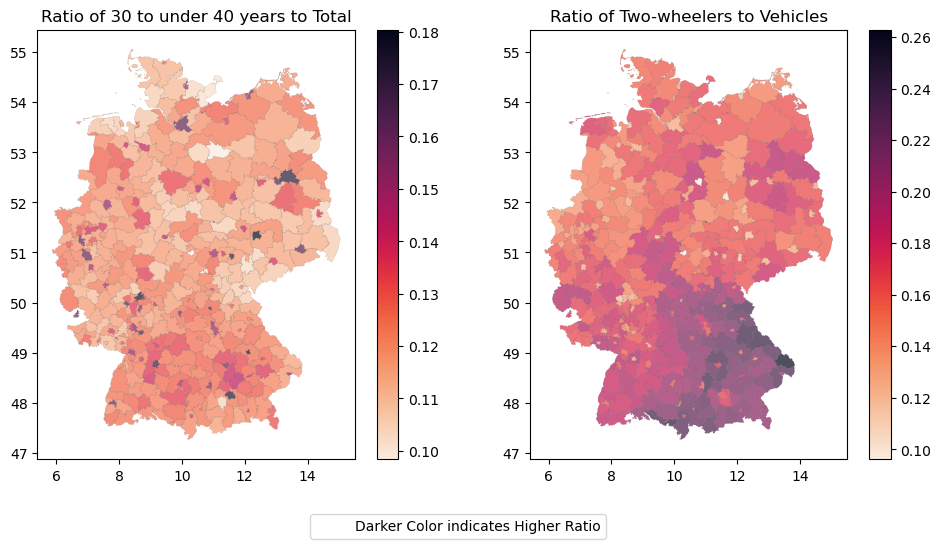

In [8]:
# A. Plot two graphs of interest side by side
fig, axs = plt.subplots(1, 2, figsize=(10, 5))


# B. Plot ratio of younger people on the left
dataproject.ratio = "30 to under 40 years/Total"
dataproject.plot(True, ax=axs[0])
axs[0].set_title("Ratio of 30 to under 40 years to Total")


# C. Plot ratio of two-wheeled vehicles on the right
dataproject.ratio = "two-wheelers/vehicles"
dataproject.plot(True, ax=axs[1])
axs[1].set_title("Ratio of Two-wheelers to Vehicles")


# D. Create a custom legend
legend_label = "Darker Color indicates Higher Ratio"
fig.legend([legend_label], loc="lower center", bbox_to_anchor=(0.5, -0.1))


# E. Adjust the layout and spacing between subplots
plt.tight_layout()


# F. Show the plots
plt.show()

In this example, we show that “younger” counties generally seem to own less two-wheeled vehicles, as their respective distribution patterns match each other. This is especially obvious in the big cities, which simultaneously have a comparatively young population and low concentration of two-wheeled vehicles. This relationship might come as a surprise in the global context, as cities are often associated with a great number of two-wheeled vehicles, such as scooters.

There are several factors which might play a role in explaining this phenomenon. Firstly, bikes and other non-motorized vehicles are excluded from our data. We suspect that if non-motorized vehicles would have been included, the share of two-wheeled vehicles in the big cities would be much bigger. 
Secondly, public transportation is a good substitute in an urban environment for motorised vehicles. Consequently, young people don’t have the necessity to rely on two-wheeled vehicles for their mobility, which might explain the relatively low share relative to the rural population.
Furthermore, younger people are generally assumed to be more cautious about the environment and thus relying on environmentally friendly transportation opportunities. This behaviour rules out the extensive usage of two-wheeled vehicles. 


# Conclusion

In conclusion, in this project we imported, cleaned, merged and plotted data on age and motor vehicle distribution in Germany. This was based on data provided by the german federal statistics office. 

We found that older people are far more present in rural areas while younger people mostly live in cities and urban areas like Berlin and Hamburg. There is also a clear east-west divide in Germany with the east being significantly older. 

Moreover, trends in motor vehicle distribution are determined. For example, campers are most commonly found in either the north or the south of Germany which overlaps with popualar german holiday spots. Furthermore, petrol cars are more common in the east and west, while diesel cars tend to be located to the north and south.

We then delve deeper in the possible negative correlation between two wheeled vehicles and the age group of 30 to under 40. We also present possible reasons for this relationship. These include the wide availability of public transport. However, we acknoledge that these results might look very different if non-motorized two-wheeled vehicles, such as bikes, would have been included.